# Análise e tratamento da base de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn.preprocessing as skp
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("data/Live.csv")

### Remoção de colunas com dados irrelevantes

Ao abrir o arquivo, percebos a existência de colunas vazias e dados irrelevantes, então iremos removê-las.

In [3]:
del df['status_id']
del df['Column1']
del df['Column2']
del df['Column3']
del df['Column4']

### Transformação dos dados

A coluna "status_published", como o nome indica, contém os dados sobre as datas e horários das publicações. Mas para que a máquina considere esses dados de forma independente, teremos de separar esses dados em diferentes colunas.

In [4]:
df['day'] = (pd.to_datetime(df['status_published']).dt.day).astype(int)
df['month'] = (pd.to_datetime(df['status_published']).dt.month).astype(int)
df['year'] = (pd.to_datetime(df['status_published']).dt.year).astype(int)
df['hour'] = (pd.to_datetime(df['status_published']).dt.hour).astype(int)
del df['status_published']

### Correlação

A fim de reduzir a dimensionalidade do problema, vamos observar se há a presença de dados correlacionados

In [5]:
corr_matrix = df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,day,month,year,hour
num_reactions,1.000000,0.150843,0.250723,0.994923,0.305003,0.267752,0.176028,0.075138,0.124326,-0.006292,-0.114712,-0.042703,0.017016
num_comments,0.150843,1.000000,0.640637,0.101687,0.521223,0.162394,0.325048,0.236453,0.225184,-0.009402,0.021358,0.132399,0.002515
num_shares,0.250723,0.640637,1.000000,0.172492,0.820000,0.407628,0.399826,0.199970,0.312513,-0.011513,-0.023500,0.189782,-0.050917
num_likes,0.994923,0.101687,0.172492,1.000000,0.209308,0.207800,0.120784,0.052169,0.087431,-0.006838,-0.111233,-0.065528,0.021375
num_loves,0.305003,0.521223,0.820000,0.209308,1.000000,0.508798,0.507830,0.207600,0.371001,0.001897,-0.059897,0.204702,-0.042705
num_wows,0.267752,0.162394,0.407628,0.207800,0.508798,1.000000,0.287756,0.086503,0.183087,0.009836,-0.062339,0.101530,-0.002816
num_hahas,0.176028,0.325048,0.399826,0.120784,0.507830,0.287756,1.000000,0.141421,0.211910,0.004075,-0.038284,0.113236,-0.006964
num_sads,0.075138,0.236453,0.199970,0.052169,0.207600,0.086503,0.141421,1.000000,0.142072,-0.003213,0.023040,0.067446,0.020918
num_angrys,0.124326,0.225184,0.312513,0.087431,0.371001,0.183087,0.211910,0.142072,1.000000,-0.013116,-0.026555,0.100654,-0.012327
day,-0.006292,-0.009402,-0.011513,-0.006838,0.001897,0.009836,0.004075,-0.003213,-0.013116,1.000000,0.018530,-0.048590,0.004608


Como se pode observar, há, de fato, colunas com alta correlação. Iremos eliminá-las

In [6]:
corr_matrix = corr_matrix.abs()

# Triangulo superior da matriz de correlação
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 

# Escolhendo as colunas com correlação >80%
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]  

# Excluindo tais colunas
df.drop(df[to_drop], axis = 1, inplace=True)

### Codificação dos dados qualitativos e PCA

Para as medidas de tempo, faremos o encoding por meio do One Hot Encoding.

In [7]:
ohe = skp.OneHotEncoder(sparse=False)

Para tal, usaremos a função abaixo. Tal função irá receber uma coluna como parâmetro uma coluna de nosso Data Frame(df), e a transformará em diferentes colunas, cada uma representando um elemento da coluna anterior.

In [8]:
def encode_column(column_name):
    global df
    encoded = ohe.fit_transform(df[column_name].values.reshape(-1, 1))
    encoded = pd.DataFrame(encoded,index= df.index).drop(columns = {len(encoded[0])-1}) 
    col_names = []
    for i in range(len(encoded.columns)):
        col_names.append(column_name + '_' + str(i))
    encoded.columns = col_names
    df = df.join(encoded)
    del df[column_name]

Agora, só resta aplicar a função em todas as colunas qualitativas

In [9]:
encode_column('year')
encode_column('month')
encode_column('day')
encode_column('hour')

Já para o status_type, usaremos um label encoder.

In [10]:
le = skp.LabelEncoder()
df['status_type'] = le.fit_transform(df['status_type'])

Visando reduzir a dimensionalidade do conjunto de dados, iremos aplicar o PCA, de forma a reduzir o conjunto para apenas duas dimensões.

In [11]:
pca = PCA(n_components=2)
X = pca.fit_transform(df)

# Approach 1: Hierárquico

In [13]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

Usaremos o dendrograma como uma ferramenta para nos auxiliar na escolha do número de clusters, uma vez que ele nos possibilita visualizar de maneira clara a distância entre os clusters gerados, representadas no eixo Y.\
Também usaremos o valor de silhueta, que é uma medida que indica quão similar um objeto é em relação ao seu cluster, em comparação à outros clusters. O valor varia no intervalo [-1, 1], com valores mais altos indicando que os objetos combinam com seus clusters e se diferenciam dos clusters vizinhos.

Dessa forma, escolheremos um número cuja tenha máxima distância intercluster e o maior valor de silhueta.

## Single Linkage

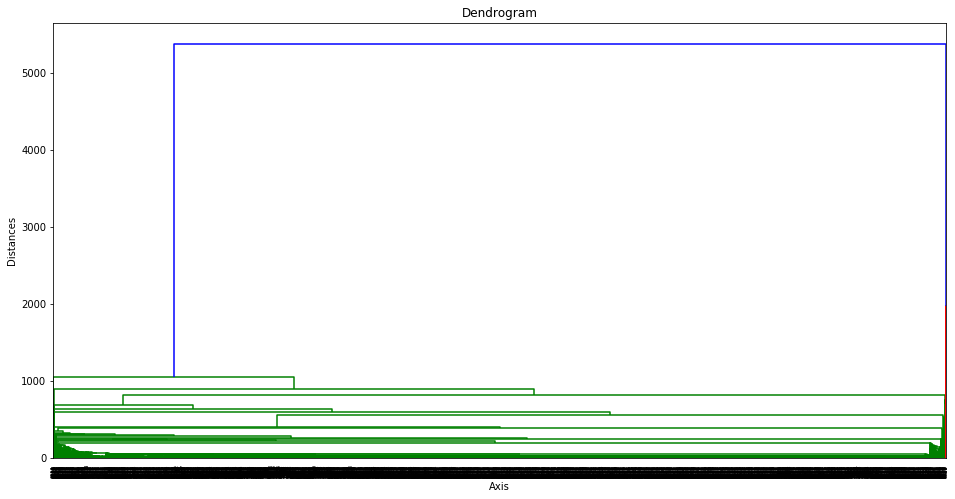

In [14]:
plt.figure(figsize = (16,8))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Distances')
plt.show()

Como se pode observar, com dois clusters se obtém a máxima distância intercluster. Agora, para confirmar os dados fornecidos pelo dendrograma, vamos visualizar o silhouette score em um intervalo de número de clusters.

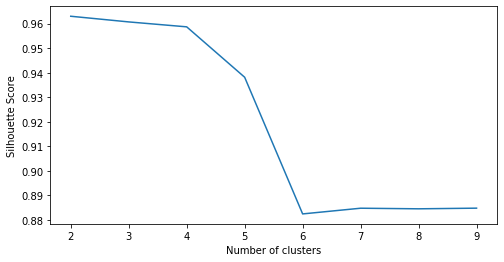

In [15]:
ss_sl = []
for i in range(2, 10):
    h_sl = AgglomerativeClustering(n_clusters = i, linkage = 'single')
    h_sl.fit(X)
    ss_sl.append(silhouette_score(X, h_sl.labels_, metric = 'euclidean'))
plt.figure(figsize = (8, 4))
plt.plot(range(2, 10), ss_sl)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Enfim, podemos criar e treinar nosso modelo.

In [16]:
hsl = AgglomerativeClustering(n_clusters = 2, linkage = 'single')
y_hsl = hsl.fit_predict(X)

## Complete Linkage

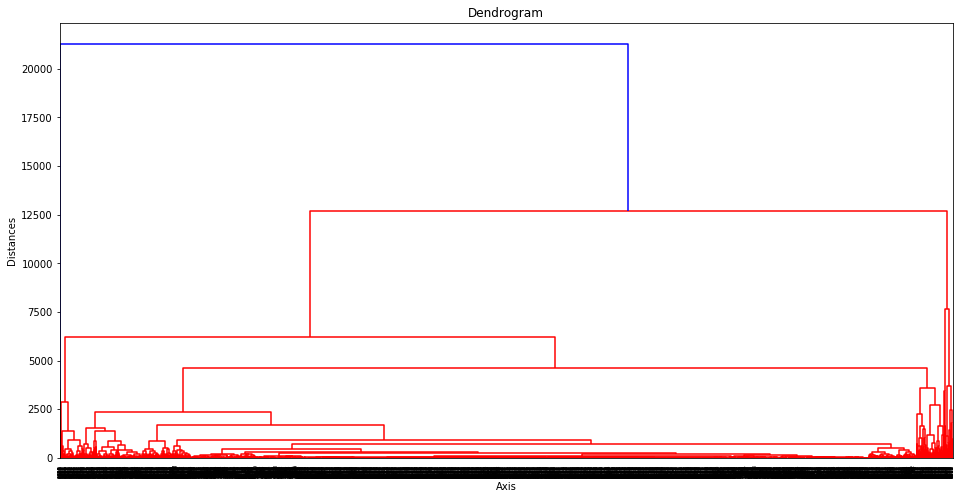

In [17]:
plt.figure(figsize = (16,8))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Distances')
plt.show()

Agora, entre 2 e 3 clusters se obtém a máxima distância intercluster. Agora, para confirmar os dados fornecidos pelo dendrograma, vamos visualizar o silhouette score em um intervalo de número de clusters.

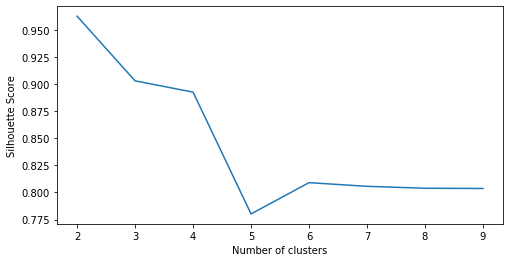

In [18]:
ss_cl = []
for i in range(2, 10):
    h_cl = AgglomerativeClustering(n_clusters = i, linkage = 'complete')
    h_cl.fit(X)
    ss_cl.append(silhouette_score(X, h_cl.labels_, metric = 'euclidean'))
plt.figure(figsize = (8, 4))
plt.plot(range(2, 10), ss_cl)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Como podemos ver, com 2 clusters obtivemos um silhouette score maior, então podemos criar e treinar nosso modelo.

In [19]:
hcl = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
y_hcl = hcl.fit_predict(X)

# Approach 2: K-Means

In [20]:
from sklearn.cluster import KMeans

Visando tornar o resultado de nosso K-Means determinístico, usaremos um valor arbritrário 10 para seu random_state, que é usado para geração dos centróides.

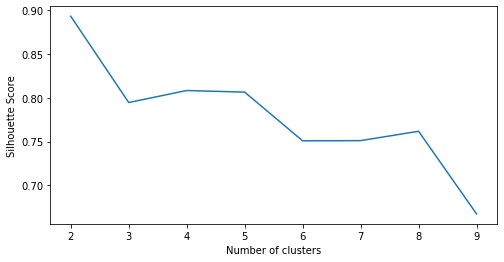

In [21]:
ss_km = []
for i in range(2, 10):
    k_m = KMeans(n_clusters = i, init = 'random', random_state = 10)
    k_m.fit(X)
    ss_km.append(silhouette_score(X, k_m.labels_, metric = 'euclidean'))
plt.figure(figsize = (8, 4))
plt.plot(range(2, 10), ss_km)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Como podemos ver, com 2 clusters obtivemos um silhouette score maior, então podemos criar e treinar nosso modelo.

In [22]:
km = KMeans(n_clusters = 2, init = 'random', random_state = 10)
y_km = km.fit_predict(X)

# Resultados

## Hierárquico

### Single Linkage

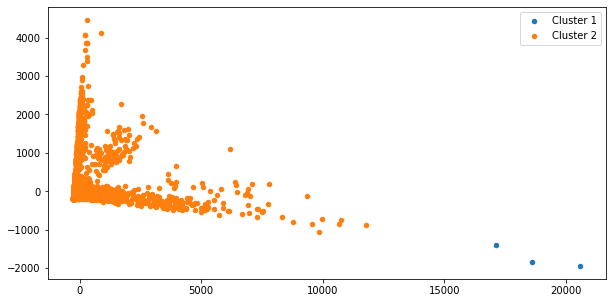

Silhouette Score = 0.9629736125145671


In [23]:
plt.figure(figsize = (10,5))
plt.scatter(X[y_hsl==0, 0], X[y_hsl==0, 1], s=20, label='Cluster 1')
plt.scatter(X[y_hsl==1, 0], X[y_hsl==1, 1], s=20, label='Cluster 2')
plt.legend()
plt.show()

print("Silhouette Score =", ss_sl[0])

### Complete Linkage

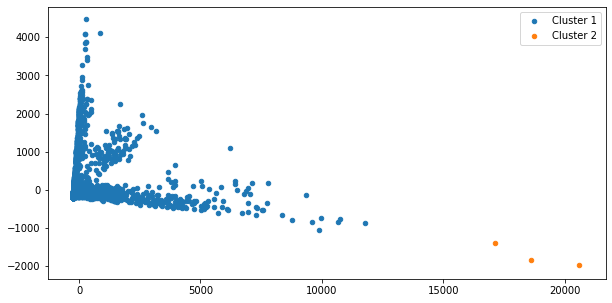

Silhouette Score = 0.9629736125145671


In [24]:
plt.figure(figsize = (10,5))
plt.scatter(X[y_hcl==0, 0], X[y_hcl==0, 1], s=20, label='Cluster 1')
plt.scatter(X[y_hcl==1, 0], X[y_hcl==1, 1], s=20, label='Cluster 2')
plt.legend()
plt.show()

print("Silhouette Score =", ss_cl[0])

## K-Means

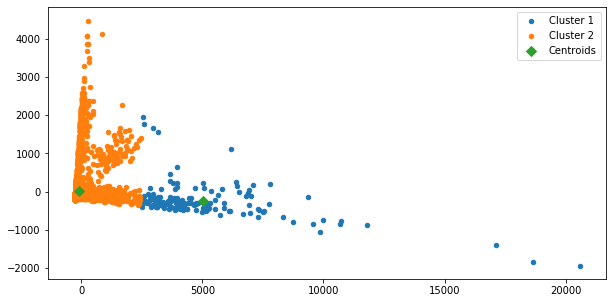

Silhouette Score = 0.8932521091586655


In [25]:
plt.figure(figsize = (10,5))
plt.scatter(X[y_km==0, 0], X[y_km==0, 1], s=20, label='Cluster 1')
plt.scatter(X[y_km==1, 0], X[y_km==1, 1], s=20, label='Cluster 2')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker = 'D', s=50, label = 'Centroids')
plt.legend()
plt.show()

print("Silhouette Score =", ss_km[0])

É visível que os valores das métricas de silhueta do método Hierárquico foram iguais no método Single Linkage e Complete Linkage, e ambos superaram o gerado pelo K-Means. Entretanto, como não há um especialista para nos indicar o significado de cada um desses clusters, não podemos avaliar a qualidade dos clusters gerados. Portanto, em nossa avaliação nos ateremos apenas às métricas geradas

# Bônus

Faremos a normalização dos dados por meio do Standard Scaler.

In [12]:
sc = skp.StandardScaler()
X_norm = sc.fit_transform(X)

## Hierárquico

### Single Linkage

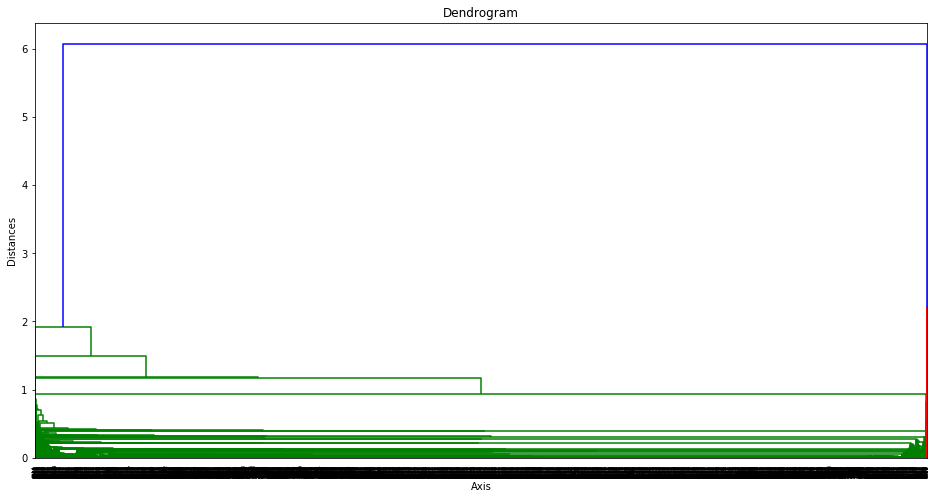

In [26]:
plt.figure(figsize = (16,8))
dendrogram = sch.dendrogram(sch.linkage(X_norm, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Distances')
plt.show()

Aparentemente, continuamos obtendo a maior distância intercluster com dois clusters. Vamos olhar o Silhouette Score para cofirmação.

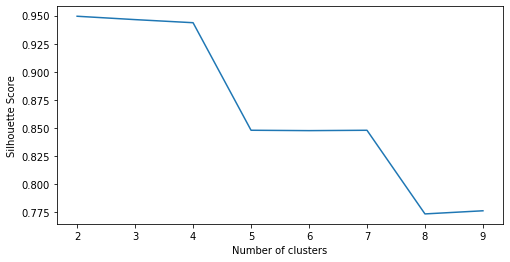

In [40]:
ss = []
for i in range(2, 10):
    h_sl = AgglomerativeClustering(n_clusters = i, linkage = 'single')
    h_sl.fit(X_norm)
    ss.append(silhouette_score(X_norm, h_sl.labels_, metric = 'euclidean'))
plt.figure(figsize = (8, 4))
plt.plot(range(2, 10), ss)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Está confirmado! Vamos então criar o modelo

In [28]:
hsl = AgglomerativeClustering(n_clusters = 2, linkage = 'single')
y_hsl = hsl.fit_predict(X_norm)

Vamos observar a distribuição

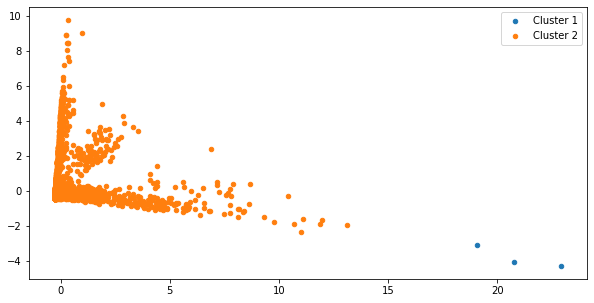

Silhouette Score = 0.949440870580188


In [41]:
plt.figure(figsize = (10,5))
plt.scatter(X_norm[y_hsl==0, 0], X_norm[y_hsl==0, 1], s=20, label='Cluster 1')
plt.scatter(X_norm[y_hsl==1, 0], X_norm[y_hsl==1, 1], s=20, label='Cluster 2')
plt.legend()
plt.show()

print("Silhouette Score =", ss[0])

Aparentemente não houveram alterações na distribuição, mas houve uma queda no valor da silhueta.

### Complete Linkage

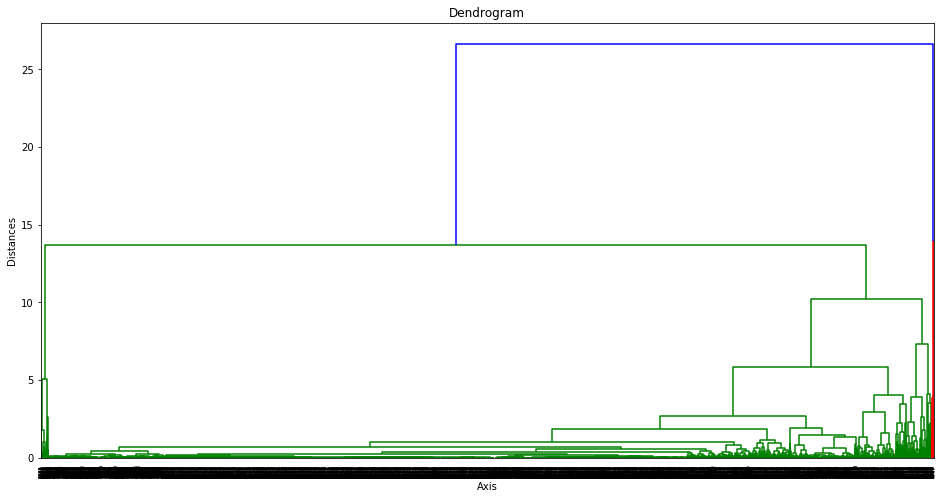

In [37]:
plt.figure(figsize = (16,8))
dendrogram = sch.dendrogram(sch.linkage(X_norm, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Distances')
plt.show()

Aparentemente, continuamos obtendo a maior distância intercluster com 2 ou 3 clusters. Vamos olhar o Silhouette Score para cofirmação.

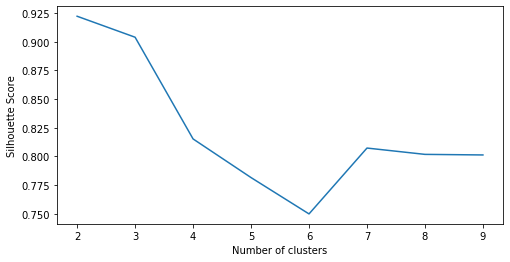

In [42]:
ss = []
for i in range(2, 10):
    h_cl = AgglomerativeClustering(n_clusters = i, linkage = 'complete')
    h_cl.fit(X_norm)
    ss.append(silhouette_score(X_norm, h_cl.labels_, metric = 'euclidean'))
plt.figure(figsize = (8, 4))
plt.plot(range(2, 10), ss)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Está confirmado! Vamos então criar o modelo

In [32]:
hcl = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
y_hcl = hcl.fit_predict(X)

Vamos observar a distribuição

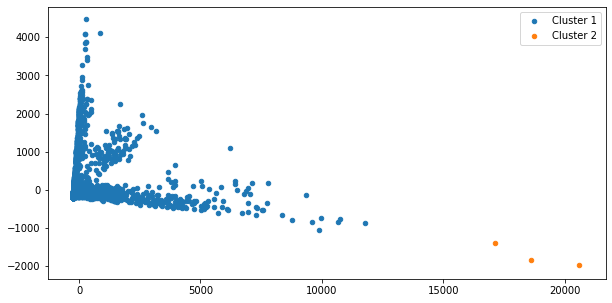

Silhouette Score = 0.9222016941761197


In [43]:
plt.figure(figsize = (10,5))
plt.scatter(X[y_hcl==0, 0], X[y_hcl==0, 1], s=20, label='Cluster 1')
plt.scatter(X[y_hcl==1, 0], X[y_hcl==1, 1], s=20, label='Cluster 2')
plt.legend()
plt.show()

print("Silhouette Score =", ss[0])

Aparentemente não houveram alterações na distribuição, mas houve uma queda no valor da silhueta.

## K-Means

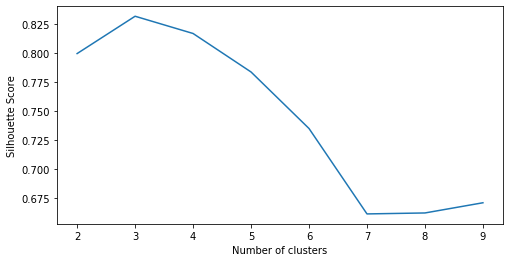

In [34]:
ss = []
for i in range(2, 10):
    k_m = KMeans(n_clusters = i, init = 'random', random_state = 10)
    k_m.fit(X_norm)
    ss.append(silhouette_score(X_norm, k_m.labels_, metric = 'euclidean'))
plt.figure(figsize = (8, 4))
plt.plot(range(2, 10), ss)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

**Opa!** Agora tivemos uma diferença no número de clusters, passamos para 3 clusters!

In [35]:
km = KMeans(n_clusters = 3, init = 'random', random_state = 10)
y_km = km.fit_predict(X_norm)

Vamos observar a distribuição

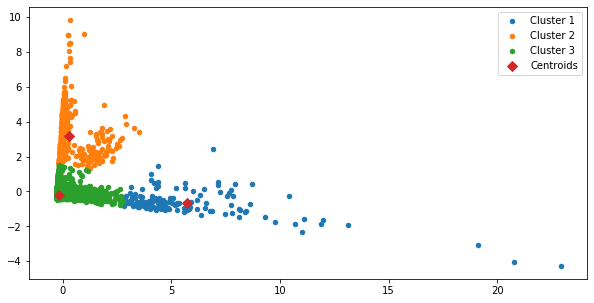

Silhouette Score = 0.8319624631319531


In [36]:
plt.figure(figsize = (10,5))
plt.scatter(X_norm[y_km==0, 0], X_norm[y_km==0, 1], s=20, label='Cluster 1')
plt.scatter(X_norm[y_km==1, 0], X_norm[y_km==1, 1], s=20, label='Cluster 2')
plt.scatter(X_norm[y_km==2, 0], X_norm[y_km==2, 1], s=20, label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker = 'D', s=50, label = 'Centroids')
plt.legend()
plt.show()

print("Silhouette Score =", ss[1])

Apesar de ter sido alterado o número de clusters, obtivemos uma queda em nossa métrica de silhueta